In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , roc_auc_score 
from sklearn import metrics

In [2]:
white = pd.read_csv('datasets/winequality-white.csv' , delimiter = ';')
red = pd.read_csv('datasets/winequality-red.csv' , delimiter = ';')

# White Wine

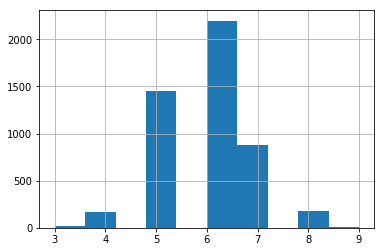

In [3]:
white['quality'].hist()

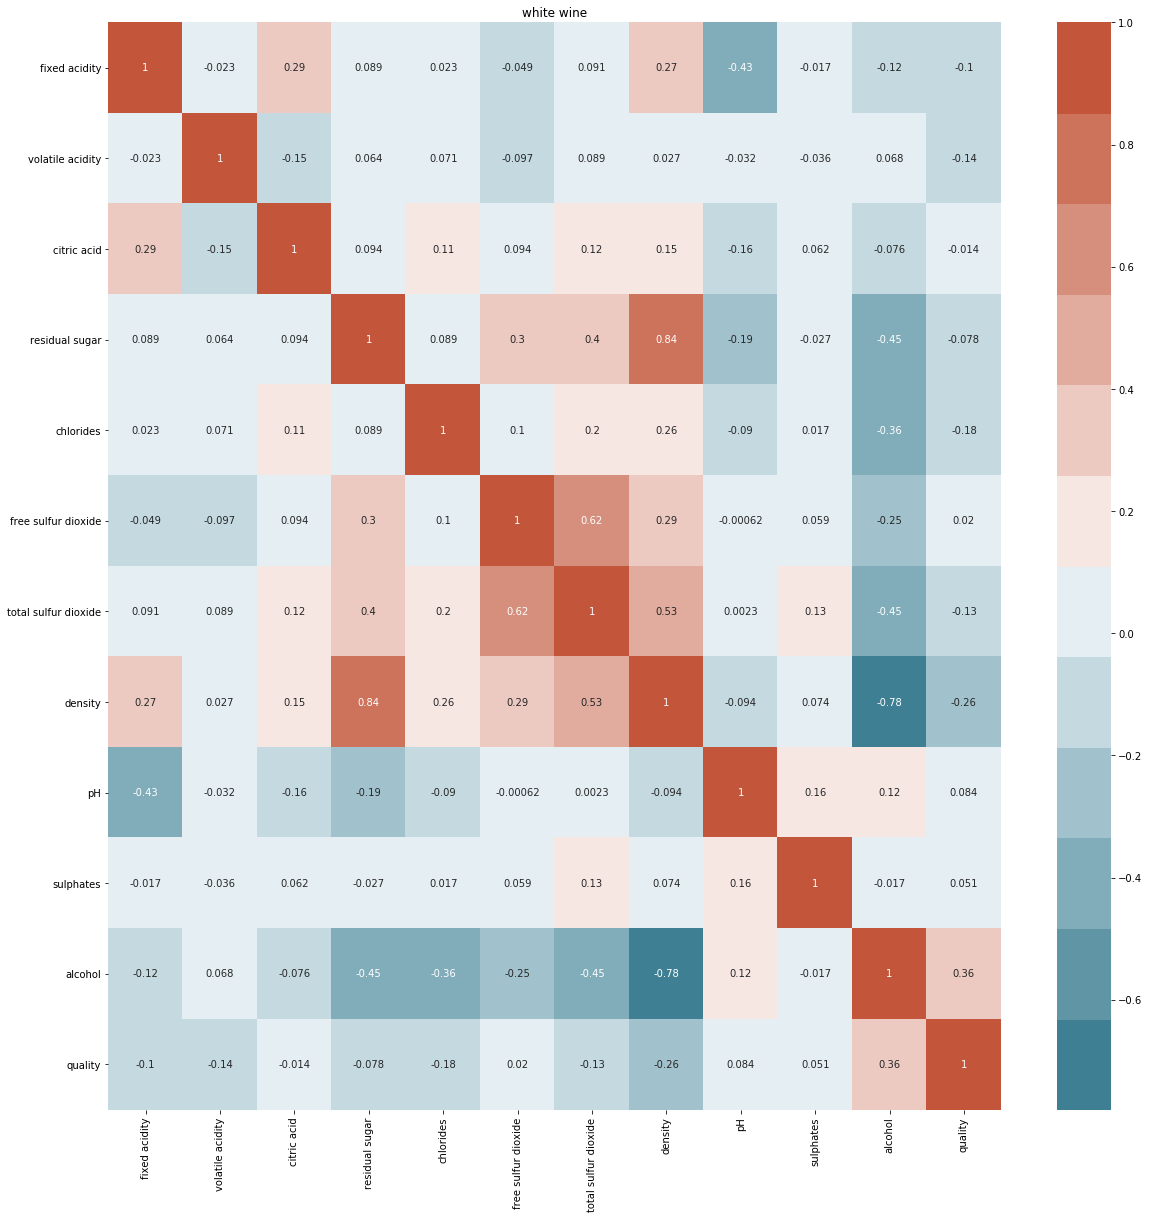

In [65]:
plt.figure(figsize=(20, 20))
df_corr = white.corr()
sns.heatmap(df_corr, cmap=sns.diverging_palette(220, 20, n=12), annot=True)
plt.title("white wine")
plt.show()

In [4]:
for i in range(len(white)):
    if white['quality'].iloc[i] == 3 or white['quality'].iloc[i] == 4  :
        white['quality'].iloc[i] = 0
    if  white['quality'].iloc[i] == 6 or white['quality'].iloc[i] == 5 :
        white['quality'].iloc[i] = 1
    if white['quality'].iloc[i] == 7 or white['quality'].iloc[i] == 8 or white['quality'].iloc[i] == 9 :
        white['quality'].iloc[i] = 2
    print('number {} is done!'.format(i))

/home/mars/.local/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


number 0 is done!
number 1 is done!
number 2 is done!
number 3 is done!
number 4 is done!
number 5 is done!
number 6 is done!
number 7 is done!
number 8 is done!
number 9 is done!
number 10 is done!
number 11 is done!
number 12 is done!
number 13 is done!
number 14 is done!
number 15 is done!
number 16 is done!
number 17 is done!
number 18 is done!
number 19 is done!
number 20 is done!
number 21 is done!
number 22 is done!
number 23 is done!
number 24 is done!
number 25 is done!
number 26 is done!
number 27 is done!
number 28 is done!
number 29 is done!
number 30 is done!
number 31 is done!
number 32 is done!
number 33 is done!
number 34 is done!
number 35 is done!
number 36 is done!
number 37 is done!
number 38 is done!
number 39 is done!
number 40 is done!
number 41 is done!
number 42 is done!
number 43 is done!
number 44 is done!
number 45 is done!
number 46 is done!
number 47 is done!
number 48 is done!
number 49 is done!
number 50 is done!
number 51 is done!
number 52 is done!
num

number 425 is done!
number 426 is done!
number 427 is done!
number 428 is done!
number 429 is done!
number 430 is done!
number 431 is done!
number 432 is done!
number 433 is done!
number 434 is done!
number 435 is done!
number 436 is done!
number 437 is done!
number 438 is done!
number 439 is done!
number 440 is done!
number 441 is done!
number 442 is done!
number 443 is done!
number 444 is done!
number 445 is done!
number 446 is done!
number 447 is done!
number 448 is done!
number 449 is done!
number 450 is done!
number 451 is done!
number 452 is done!
number 453 is done!
number 454 is done!
number 455 is done!
number 456 is done!
number 457 is done!
number 458 is done!
number 459 is done!
number 460 is done!
number 461 is done!
number 462 is done!
number 463 is done!
number 464 is done!
number 465 is done!
number 466 is done!
number 467 is done!
number 468 is done!
number 469 is done!
number 470 is done!
number 471 is done!
number 472 is done!
number 473 is done!
number 474 is done!


number 836 is done!
number 837 is done!
number 838 is done!
number 839 is done!
number 840 is done!
number 841 is done!
number 842 is done!
number 843 is done!
number 844 is done!
number 845 is done!
number 846 is done!
number 847 is done!
number 848 is done!
number 849 is done!
number 850 is done!
number 851 is done!
number 852 is done!
number 853 is done!
number 854 is done!
number 855 is done!
number 856 is done!
number 857 is done!
number 858 is done!
number 859 is done!
number 860 is done!
number 861 is done!
number 862 is done!
number 863 is done!
number 864 is done!
number 865 is done!
number 866 is done!
number 867 is done!
number 868 is done!
number 869 is done!
number 870 is done!
number 871 is done!
number 872 is done!
number 873 is done!
number 874 is done!
number 875 is done!
number 876 is done!
number 877 is done!
number 878 is done!
number 879 is done!
number 880 is done!
number 881 is done!
number 882 is done!
number 883 is done!
number 884 is done!
number 885 is done!


number 1240 is done!
number 1241 is done!
number 1242 is done!
number 1243 is done!
number 1244 is done!
number 1245 is done!
number 1246 is done!
number 1247 is done!
number 1248 is done!
number 1249 is done!
number 1250 is done!
number 1251 is done!
number 1252 is done!
number 1253 is done!
number 1254 is done!
number 1255 is done!
number 1256 is done!
number 1257 is done!
number 1258 is done!
number 1259 is done!
number 1260 is done!
number 1261 is done!
number 1262 is done!
number 1263 is done!
number 1264 is done!
number 1265 is done!
number 1266 is done!
number 1267 is done!
number 1268 is done!
number 1269 is done!
number 1270 is done!
number 1271 is done!
number 1272 is done!
number 1273 is done!
number 1274 is done!
number 1275 is done!
number 1276 is done!
number 1277 is done!
number 1278 is done!
number 1279 is done!
number 1280 is done!
number 1281 is done!
number 1282 is done!
number 1283 is done!
number 1284 is done!
number 1285 is done!
number 1286 is done!
number 1287 i

number 1632 is done!
number 1633 is done!
number 1634 is done!
number 1635 is done!
number 1636 is done!
number 1637 is done!
number 1638 is done!
number 1639 is done!
number 1640 is done!
number 1641 is done!
number 1642 is done!
number 1643 is done!
number 1644 is done!
number 1645 is done!
number 1646 is done!
number 1647 is done!
number 1648 is done!
number 1649 is done!
number 1650 is done!
number 1651 is done!
number 1652 is done!
number 1653 is done!
number 1654 is done!
number 1655 is done!
number 1656 is done!
number 1657 is done!
number 1658 is done!
number 1659 is done!
number 1660 is done!
number 1661 is done!
number 1662 is done!
number 1663 is done!
number 1664 is done!
number 1665 is done!
number 1666 is done!
number 1667 is done!
number 1668 is done!
number 1669 is done!
number 1670 is done!
number 1671 is done!
number 1672 is done!
number 1673 is done!
number 1674 is done!
number 1675 is done!
number 1676 is done!
number 1677 is done!
number 1678 is done!
number 1679 i

number 2029 is done!
number 2030 is done!
number 2031 is done!
number 2032 is done!
number 2033 is done!
number 2034 is done!
number 2035 is done!
number 2036 is done!
number 2037 is done!
number 2038 is done!
number 2039 is done!
number 2040 is done!
number 2041 is done!
number 2042 is done!
number 2043 is done!
number 2044 is done!
number 2045 is done!
number 2046 is done!
number 2047 is done!
number 2048 is done!
number 2049 is done!
number 2050 is done!
number 2051 is done!
number 2052 is done!
number 2053 is done!
number 2054 is done!
number 2055 is done!
number 2056 is done!
number 2057 is done!
number 2058 is done!
number 2059 is done!
number 2060 is done!
number 2061 is done!
number 2062 is done!
number 2063 is done!
number 2064 is done!
number 2065 is done!
number 2066 is done!
number 2067 is done!
number 2068 is done!
number 2069 is done!
number 2070 is done!
number 2071 is done!
number 2072 is done!
number 2073 is done!
number 2074 is done!
number 2075 is done!
number 2076 i

number 2422 is done!
number 2423 is done!
number 2424 is done!
number 2425 is done!
number 2426 is done!
number 2427 is done!
number 2428 is done!
number 2429 is done!
number 2430 is done!
number 2431 is done!
number 2432 is done!
number 2433 is done!
number 2434 is done!
number 2435 is done!
number 2436 is done!
number 2437 is done!
number 2438 is done!
number 2439 is done!
number 2440 is done!
number 2441 is done!
number 2442 is done!
number 2443 is done!
number 2444 is done!
number 2445 is done!
number 2446 is done!
number 2447 is done!
number 2448 is done!
number 2449 is done!
number 2450 is done!
number 2451 is done!
number 2452 is done!
number 2453 is done!
number 2454 is done!
number 2455 is done!
number 2456 is done!
number 2457 is done!
number 2458 is done!
number 2459 is done!
number 2460 is done!
number 2461 is done!
number 2462 is done!
number 2463 is done!
number 2464 is done!
number 2465 is done!
number 2466 is done!
number 2467 is done!
number 2468 is done!
number 2469 i

number 2821 is done!
number 2822 is done!
number 2823 is done!
number 2824 is done!
number 2825 is done!
number 2826 is done!
number 2827 is done!
number 2828 is done!
number 2829 is done!
number 2830 is done!
number 2831 is done!
number 2832 is done!
number 2833 is done!
number 2834 is done!
number 2835 is done!
number 2836 is done!
number 2837 is done!
number 2838 is done!
number 2839 is done!
number 2840 is done!
number 2841 is done!
number 2842 is done!
number 2843 is done!
number 2844 is done!
number 2845 is done!
number 2846 is done!
number 2847 is done!
number 2848 is done!
number 2849 is done!
number 2850 is done!
number 2851 is done!
number 2852 is done!
number 2853 is done!
number 2854 is done!
number 2855 is done!
number 2856 is done!
number 2857 is done!
number 2858 is done!
number 2859 is done!
number 2860 is done!
number 2861 is done!
number 2862 is done!
number 2863 is done!
number 2864 is done!
number 2865 is done!
number 2866 is done!
number 2867 is done!
number 2868 i

number 3212 is done!
number 3213 is done!
number 3214 is done!
number 3215 is done!
number 3216 is done!
number 3217 is done!
number 3218 is done!
number 3219 is done!
number 3220 is done!
number 3221 is done!
number 3222 is done!
number 3223 is done!
number 3224 is done!
number 3225 is done!
number 3226 is done!
number 3227 is done!
number 3228 is done!
number 3229 is done!
number 3230 is done!
number 3231 is done!
number 3232 is done!
number 3233 is done!
number 3234 is done!
number 3235 is done!
number 3236 is done!
number 3237 is done!
number 3238 is done!
number 3239 is done!
number 3240 is done!
number 3241 is done!
number 3242 is done!
number 3243 is done!
number 3244 is done!
number 3245 is done!
number 3246 is done!
number 3247 is done!
number 3248 is done!
number 3249 is done!
number 3250 is done!
number 3251 is done!
number 3252 is done!
number 3253 is done!
number 3254 is done!
number 3255 is done!
number 3256 is done!
number 3257 is done!
number 3258 is done!
number 3259 i

number 3610 is done!
number 3611 is done!
number 3612 is done!
number 3613 is done!
number 3614 is done!
number 3615 is done!
number 3616 is done!
number 3617 is done!
number 3618 is done!
number 3619 is done!
number 3620 is done!
number 3621 is done!
number 3622 is done!
number 3623 is done!
number 3624 is done!
number 3625 is done!
number 3626 is done!
number 3627 is done!
number 3628 is done!
number 3629 is done!
number 3630 is done!
number 3631 is done!
number 3632 is done!
number 3633 is done!
number 3634 is done!
number 3635 is done!
number 3636 is done!
number 3637 is done!
number 3638 is done!
number 3639 is done!
number 3640 is done!
number 3641 is done!
number 3642 is done!
number 3643 is done!
number 3644 is done!
number 3645 is done!
number 3646 is done!
number 3647 is done!
number 3648 is done!
number 3649 is done!
number 3650 is done!
number 3651 is done!
number 3652 is done!
number 3653 is done!
number 3654 is done!
number 3655 is done!
number 3656 is done!
number 3657 i

number 4012 is done!
number 4013 is done!
number 4014 is done!
number 4015 is done!
number 4016 is done!
number 4017 is done!
number 4018 is done!
number 4019 is done!
number 4020 is done!
number 4021 is done!
number 4022 is done!
number 4023 is done!
number 4024 is done!
number 4025 is done!
number 4026 is done!
number 4027 is done!
number 4028 is done!
number 4029 is done!
number 4030 is done!
number 4031 is done!
number 4032 is done!
number 4033 is done!
number 4034 is done!
number 4035 is done!
number 4036 is done!
number 4037 is done!
number 4038 is done!
number 4039 is done!
number 4040 is done!
number 4041 is done!
number 4042 is done!
number 4043 is done!
number 4044 is done!
number 4045 is done!
number 4046 is done!
number 4047 is done!
number 4048 is done!
number 4049 is done!
number 4050 is done!
number 4051 is done!
number 4052 is done!
number 4053 is done!
number 4054 is done!
number 4055 is done!
number 4056 is done!
number 4057 is done!
number 4058 is done!
number 4059 i

number 4411 is done!
number 4412 is done!
number 4413 is done!
number 4414 is done!
number 4415 is done!
number 4416 is done!
number 4417 is done!
number 4418 is done!
number 4419 is done!
number 4420 is done!
number 4421 is done!
number 4422 is done!
number 4423 is done!
number 4424 is done!
number 4425 is done!
number 4426 is done!
number 4427 is done!
number 4428 is done!
number 4429 is done!
number 4430 is done!
number 4431 is done!
number 4432 is done!
number 4433 is done!
number 4434 is done!
number 4435 is done!
number 4436 is done!
number 4437 is done!
number 4438 is done!
number 4439 is done!
number 4440 is done!
number 4441 is done!
number 4442 is done!
number 4443 is done!
number 4444 is done!
number 4445 is done!
number 4446 is done!
number 4447 is done!
number 4448 is done!
number 4449 is done!
number 4450 is done!
number 4451 is done!
number 4452 is done!
number 4453 is done!
number 4454 is done!
number 4455 is done!
number 4456 is done!
number 4457 is done!
number 4458 i

number 4811 is done!
number 4812 is done!
number 4813 is done!
number 4814 is done!
number 4815 is done!
number 4816 is done!
number 4817 is done!
number 4818 is done!
number 4819 is done!
number 4820 is done!
number 4821 is done!
number 4822 is done!
number 4823 is done!
number 4824 is done!
number 4825 is done!
number 4826 is done!
number 4827 is done!
number 4828 is done!
number 4829 is done!
number 4830 is done!
number 4831 is done!
number 4832 is done!
number 4833 is done!
number 4834 is done!
number 4835 is done!
number 4836 is done!
number 4837 is done!
number 4838 is done!
number 4839 is done!
number 4840 is done!
number 4841 is done!
number 4842 is done!
number 4843 is done!
number 4844 is done!
number 4845 is done!
number 4846 is done!
number 4847 is done!
number 4848 is done!
number 4849 is done!
number 4850 is done!
number 4851 is done!
number 4852 is done!
number 4853 is done!
number 4854 is done!
number 4855 is done!
number 4856 is done!
number 4857 is done!
number 4858 i

In [5]:
X_White = white.drop('quality', axis = 1).values
y_White = white['quality'].values

In [ ]:
scalar = StandardScaler()
X_White = scalar.fit_transform(X_White)

In [6]:
X_White_train, X_White_test, y_White_train, y_White_test = train_test_split(X_White , y_White  , test_size = 0.2 , random_state = 42)

# Functions

In [43]:
def LogisticRegression_algorithm(X_train, X_test, y_train, y_test):
    
    global y_pred_LG
    global LG_pipeline
    global y_prob_LG
    
    steps = [('scaler', StandardScaler()),
             ('LogisticRegression', LogisticRegression(random_state = 0))]
    
    LG_pipeline = Pipeline(steps)

    
    LG_pipeline.fit(X_train , y_train)
    
    y_pred_LG = LG_pipeline.predict(X_test)
    
    y_prob_LG = LG_pipeline.predict_proba(X_test)
    
    print("Accuracy: {0:.2f} %".format(LG_pipeline.score(X_test, y_test) * 100))
    print(classification_report(y_test, y_pred_LG))

In [16]:
def kNN_algorithm(X_train, X_test, y_train, y_test , k):
    
    global y_pred_kNN
    global kNN_pipeline
    
    steps = [('impute' , SimpleImputer(missing_values = 0, strategy='mean')),
             ('sclaer', StandardScaler()),
             ('kNN', KNeighborsClassifier(n_neighbors = k))]
    
    kNN_pipeline = Pipeline(steps)
    
    kNN_pipeline.fit(X_train , y_train)
    
    y_pred_kNN = kNN_pipeline.predict(X_test)
    
    print(classification_report(y_test , y_pred_kNN))
    print('kNN algorithm acuracy is : {0:.2f} %'.format(kNN_pipeline.score(X_test , y_test) * 100))

In [17]:
def SVM_algorithm(X_train, X_test, y_train, y_test):
    
    global y_pred_SVM
    global SVM_pipeline
    global y_prob_SVM
    
    steps = [('scaler', StandardScaler()),
             ('SVM', SVC(probability=True))]
    
    SVM_pipeline = Pipeline(steps)
    
    parameters = {'SVM__C':[1, 10, 100 , 1000],
                  'SVM__gamma':[0.1, 0.01 , 0.001]}
    
    cv = GridSearchCV(SVM_pipeline , cv = 3 , param_grid = parameters)
    
    cv.fit(X_train , y_train)
    
    y_pred_SVM = cv.predict(X_test)
    
    y_prob_SVM = cv.predict_proba(X_test)
    
    print("Accuracy: {0:.2f} %".format(cv.score(X_test, y_test) * 100))
    print(classification_report(y_test, y_pred_SVM))
    print("Tuned Model Parameters: {}".format(cv.best_params_))

In [18]:
def plot_confusion_matrix(cf_matrix , y_test , model_type , cf_size):
    if cf_size == '2x2':
        group_names = ['True Negative','False Positive','False Negative','True Positive']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = ['{}\n{}'.format(v1 ,v2) for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cf_matrix,
            annot = labels,
            cmap=sns.cubehelix_palette(100, as_cmap=True, hue=1, dark=0.30),
            fmt='',
            linewidths=1.5,
            vmin=0,
            vmax=len(y_test),
        )
        plt.title(model_type)
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cf_matrix / np.sum(cf_matrix) * 100,
            annot = True,
            cmap=sns.cubehelix_palette(100, as_cmap=True, hue=1, dark=0.30),
            fmt='.2f',
            linewidths=1.5,
            vmin=0,
            vmax=100,
        )
        plt.title(model_type)
        plt.show()

In [19]:
def plot_AUC_ROC_kNN(X_test , y_test , pipeline):
    
    probs = pipeline.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc_score(y_test, preds)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score is ' + '{0:.2f}'.format(roc_auc_score(y_test, preds)))

In [20]:
def plot_AUC_ROC_SVM(X_test , y_test , y_prob_SVM):
    
    probs = y_prob_SVM
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc_score(y_test, preds)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score is ' + '{0:.2f}'.format(roc_auc_score(y_test, preds)))

In [25]:
def calculate_and_plot_k_neighbors(X_train, X_test, y_train, y_test):
    
    neighbors = np.arange(1, 10)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors= k)
        knn.fit(X_train , y_train)
        train_accuracy[i] = knn.score(X_train, y_train)    
        test_accuracy[i] = knn.score(X_test, y_test)

    plt.figure(figsize=(10, 8))   
    plt.title('k in kNN analysis')
    plt.plot( neighbors , test_accuracy , label = 'Testing Accuracy')
    plt.plot(neighbors,train_accuracy ,label = 'Training Accuracy')
    plt.legend()
    plt.annotate('Best accuracy for this model with this k is {0:.2f} %'.format(max(test_accuracy) * 100), xy=(np.argmax(test_accuracy) + 1 , max(test_accuracy)), xytext=(5 , 0.85),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

# kNN ( k-Nearest Neighbors )

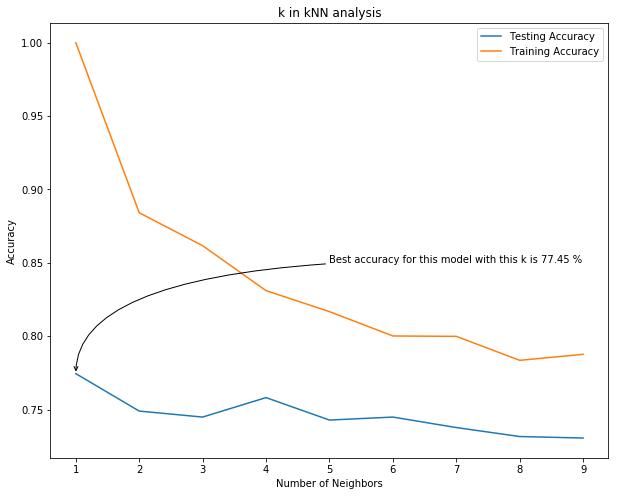

In [26]:
calculate_and_plot_k_neighbors(X_White_train, X_White_test, y_White_train, y_White_test)

In [27]:
kNN_algorithm(X_White_train, X_White_test, y_White_train, y_White_test , 1)

              precision    recall  f1-score   support

           0       0.29      0.33      0.31        30
           1       0.88      0.87      0.88       723
           2       0.70      0.72      0.71       227

   micro avg       0.82      0.82      0.82       980
   macro avg       0.63      0.64      0.63       980
weighted avg       0.82      0.82      0.82       980

kNN algorithm acuracy is : 82.04 %


In [31]:
cf_matrix_knn = confusion_matrix(y_White_test, y_pred_kNN)

In [32]:
cf_matrix_knn = pd.DataFrame(cf_matrix_knn  , index = ['Bad' ,'Medium','Good'] , columns =['Bad' ,'Medium','Good'])

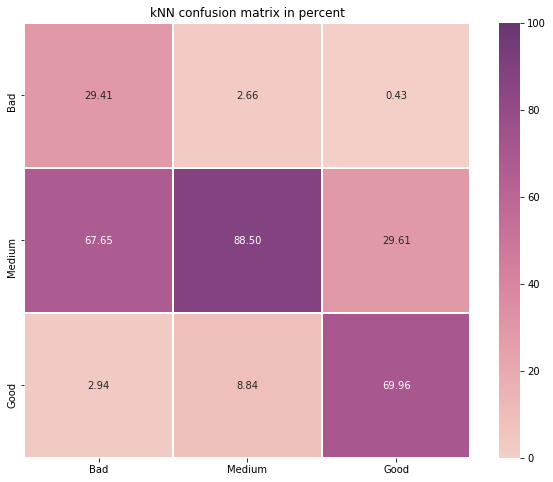

In [34]:
plot_confusion_matrix(cf_matrix_knn , y_White_test , 'kNN confusion matrix in percent' , '3x3')

# SVM (Support vector machine)

In [36]:
SVM_algorithm(X_White_train, X_White_test, y_White_train, y_White_test)

Accuracy: 81.02 %
              precision    recall  f1-score   support

           0       0.47      0.23      0.31        30
           1       0.83      0.93      0.88       723
           2       0.73      0.49      0.59       227

   micro avg       0.81      0.81      0.81       980
   macro avg       0.68      0.55      0.59       980
weighted avg       0.80      0.81      0.79       980

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.1}


In [37]:
cf_matrix_SVM = confusion_matrix(y_White_test, y_pred_SVM)

In [38]:
cf_matrix_SVM = pd.DataFrame(cf_matrix_SVM  , index = ['Bad' ,'Medium','Good'] , columns =['Bad' ,'Medium','Good'])

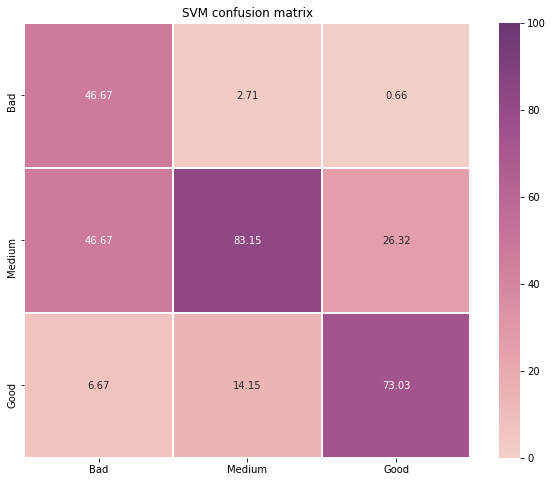

In [39]:
plot_confusion_matrix(cf_matrix_SVM , y_White_test , 'SVM confusion matrix' , '3x3')

# Red Wine

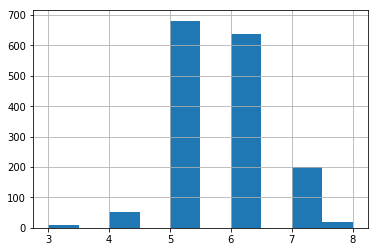

In [47]:
red['quality'].hist()

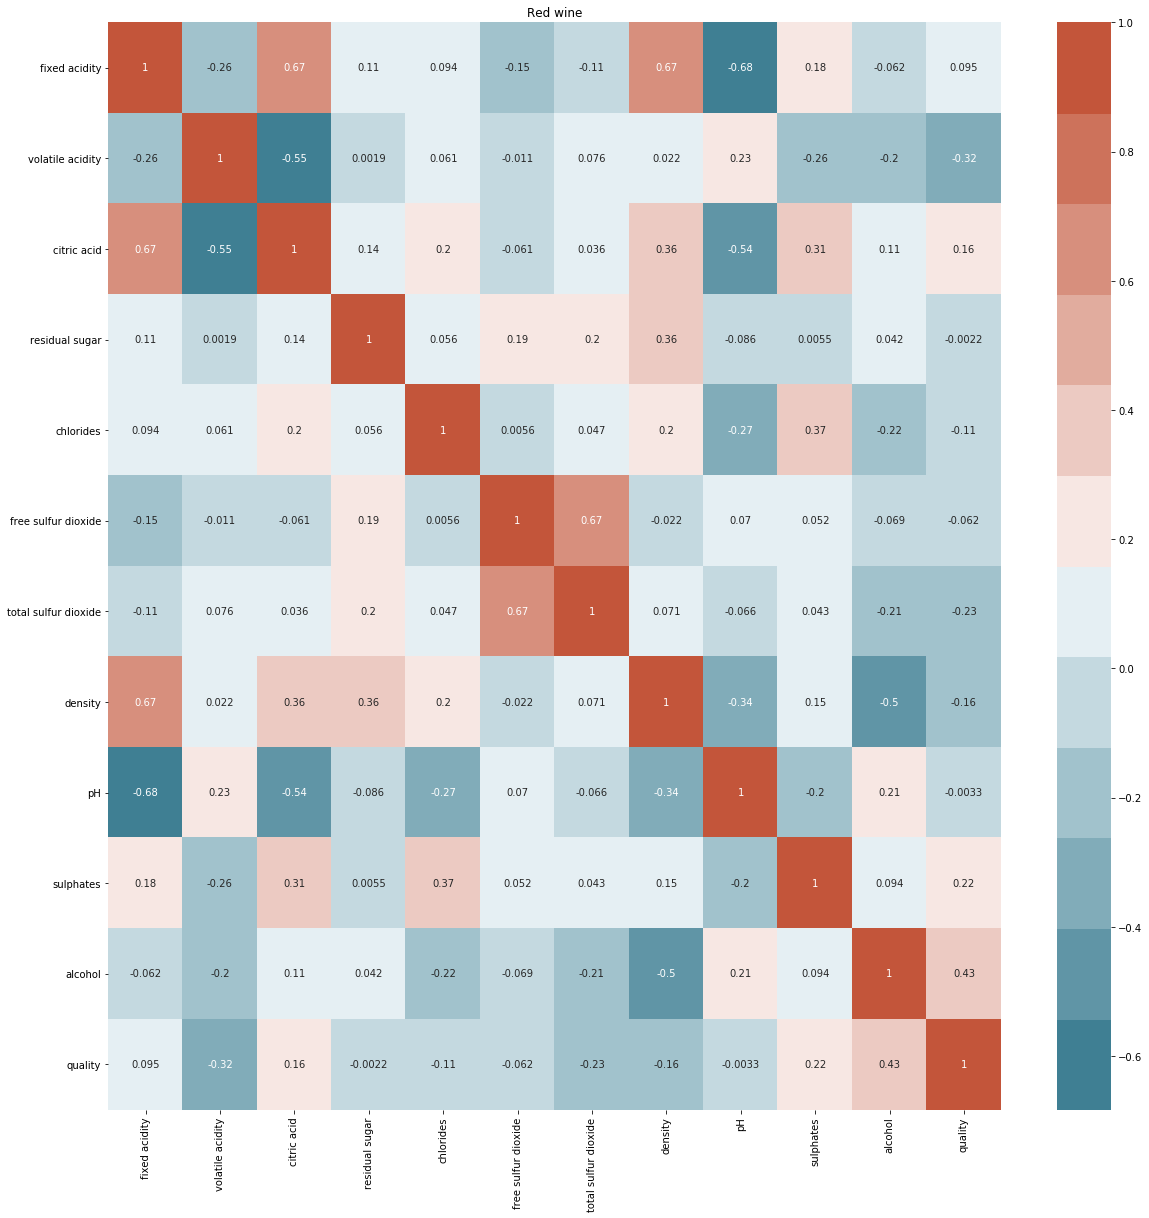

In [66]:
plt.figure(figsize=(20, 20))
df_corr = red.corr()
sns.heatmap(df_corr, cmap=sns.diverging_palette(220, 20, n=12), annot=True)
plt.title("Red wine")
plt.show()

In [48]:
for i in range(len(red)):
    if red['quality'].iloc[i] == 3 or red['quality'].iloc[i] == 4 or red['quality'].iloc[i] == 5 :
        red['quality'].iloc[i] = 0
    if  red['quality'].iloc[i] == 6 or red['quality'].iloc[i] == 7 or red['quality'].iloc[i] == 8 :
        red['quality'].iloc[i] = 1

In [49]:
X_Red = red.drop('quality', axis = 1).values
y_Red = red['quality'].values

In [50]:
scalar = StandardScaler()
X_Red = scalar.fit_transform(X_Red)

In [51]:
X_Red_train, X_Red_test, y_Red_train, y_Red_test = train_test_split(X_Red , y_Red  , test_size = 0.3 , random_state = 42)

# kNN ( k-Nearest Neighbors )

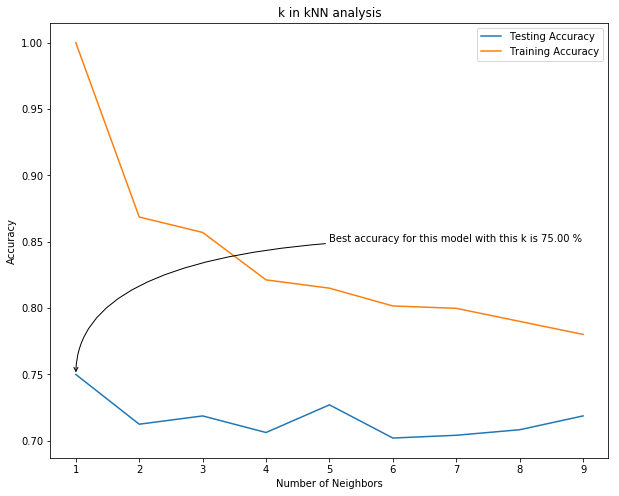

In [52]:
calculate_and_plot_k_neighbors(X_Red_train, X_Red_test, y_Red_train, y_Red_test)

In [53]:
kNN_algorithm(X_Red_train, X_Red_test, y_Red_train, y_Red_test , 1)

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       213
           1       0.76      0.81      0.79       267

   micro avg       0.75      0.75      0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480

kNN algorithm acuracy is : 75.42 %


In [54]:
cf_matrix_knn_red = confusion_matrix(y_Red_test, y_pred_kNN)

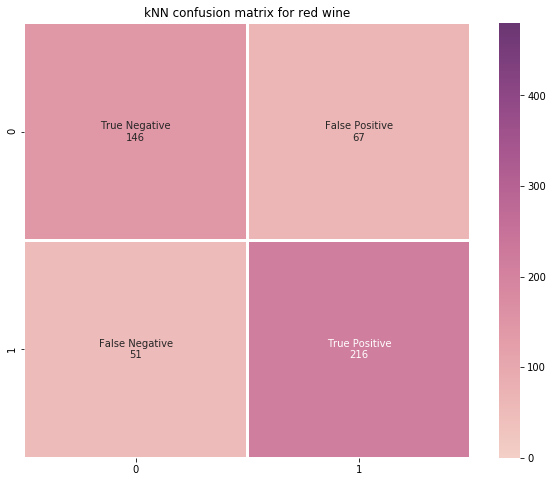

In [55]:
plot_confusion_matrix(cf_matrix_knn_red , y_Red_test , 'kNN confusion matrix for red wine' , '2x2')

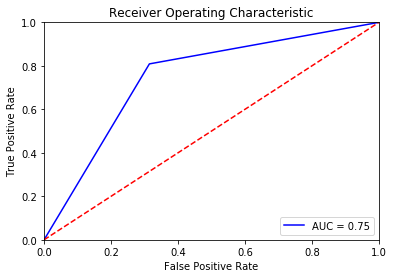

ROC AUC score is 0.75


In [56]:
plot_AUC_ROC_kNN(X_Red_test , y_Red_test , kNN_pipeline)

# SVM (Support vector machine)

In [57]:
SVM_algorithm(X_Red_train, X_Red_test, y_Red_train, y_Red_test)

Accuracy: 75.83 %
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       213
           1       0.80      0.75      0.78       267

   micro avg       0.76      0.76      0.76       480
   macro avg       0.76      0.76      0.76       480
weighted avg       0.76      0.76      0.76       480

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 0.01}


In [58]:
cf_matrix_SVM_red = confusion_matrix(y_Red_test,y_pred_SVM)

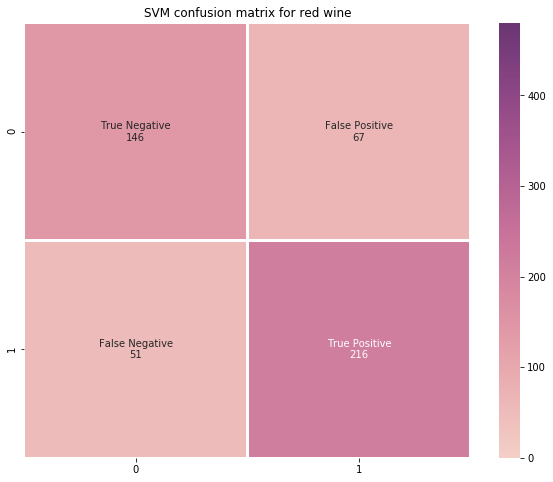

In [59]:
plot_confusion_matrix(cf_matrix_knn_red , y_Red_test , 'SVM confusion matrix for red wine' , '2x2')

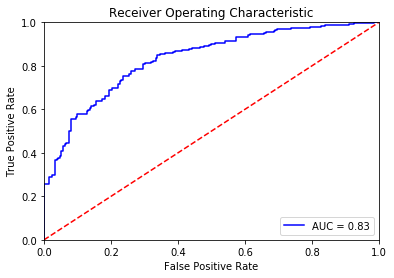

ROC AUC score is 0.83


In [60]:
plot_AUC_ROC_SVM(X_Red_test , y_Red_test , y_prob_SVM)

# Logistic Regression

In [61]:
LogisticRegression_algorithm(X_Red_train, X_Red_test, y_Red_train, y_Red_test)

Accuracy: 73.54 %
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       213
           1       0.78      0.73      0.76       267

   micro avg       0.74      0.74      0.74       480
   macro avg       0.73      0.74      0.73       480
weighted avg       0.74      0.74      0.74       480



In [62]:
cf_matrix_LG_red = confusion_matrix(y_Red_test,y_pred_LG)

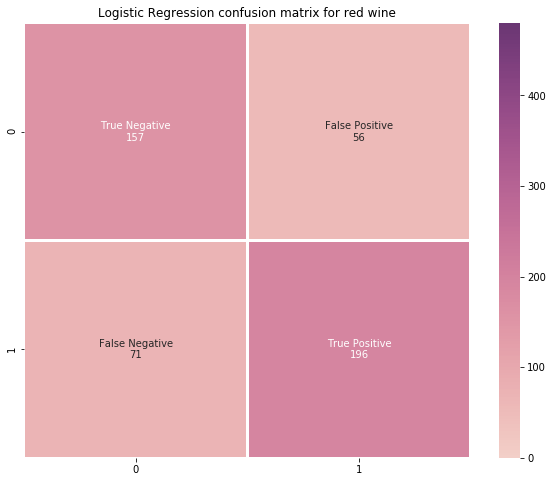

In [63]:
plot_confusion_matrix(cf_matrix_LG_red , y_Red_test , 'Logistic Regression confusion matrix for red wine' , '2x2')

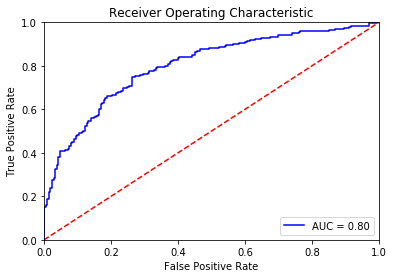

ROC AUC score is 0.80


In [64]:
plot_AUC_ROC_SVM(X_Red_test , y_Red_test , y_prob_LG)